# Thrombin ligands for pharmacophore identification

We explore thrombing ligands that will be used to create ligand-based pharmacophore models

In [1]:
import openpharmacophore as oph

import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
import nglview as nv

from collections import defaultdict
from pprint import pprint

## Load  and visualize ligands

We load the ligands from their respective smiles and draw their molecular structures

In [2]:
lig_df = pd.read_csv("ligands.csv")
lig_df

,Smiles,PDBID,LigID
0,[H]/N=C(\C1CCC(CC1)CNC(=O)[C@@H]2C=C(CN3N2C(=O...,1C4V,IH2
1,CN[C@H](Cc1ccccc1)C(=O)N2CCC[C@H]2C(=O)NCC3CCC...,1TOM,MIN
2,c1ccc(cc1)S(=O)(=O)CCN2C(=O)N3CC=C[C@H](N3C2=O...,1D6W,00R
3,c1ccc(cc1)S(=O)(=O)CCN2C(=O)N3CC=C[C@H](N3C2=O...,1D91,00P
4,[H]/N=C(/c1ccc(cc1)C[C@H](C(=O)N2CCCCC2)NC(=O)...,1DWD,MID
5,[H]/N=C(\c1ccc2c(c1)cc([nH]2)C(=O)N3CCC(CC3)Cc...,1D4P,BPP


In [3]:
def load_ligands():
    """ Load the ligands into a list of rdkit molecules."""
    ligands = []
    
    smiles = lig_df["Smiles"]
    pdb_ids = lig_df["PDBID"]
    
    for ii in range(len(smiles)):
        mol = Chem.MolFromSmiles(smiles[ii].encode("unicode_escape"))
        mol.SetProp("_Name", pdb_ids[ii])
        assert mol is not None
        ligands.append(mol)
    
    supp = Chem.SDMolSupplier("0ZI.sdf")
    mol = next(supp)
    mol.RemoveAllConformers()
    mol.SetProp("_Name", "1FPC")
    ligands.append(mol)

    print(f"Num ligands: {len(ligands)}")
    return ligands

Num ligands: 7


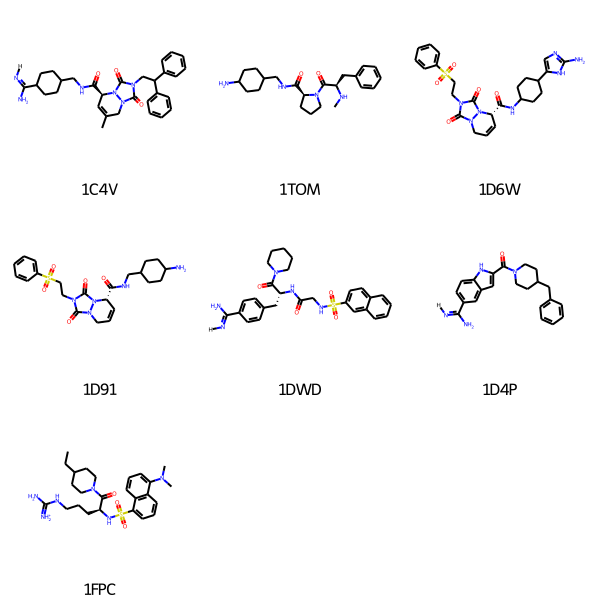

In [4]:
ligands = load_ligands()
legends = [l.GetProp("_Name") for l in ligands]
Draw.MolsToGridImage(ligands, legends=legends)

## Preparing the ligands

We'll generate different conformers for each of the ligands and add hydrogens to them
as well.

### Generating conformers

In [5]:
from e3fp.conformer.generator import ConformerGenerator

In [6]:
for ii, lig in enumerate(ligands):
    n_confs = ConformerGenerator.get_num_conformers(lig)
    print(f"Ideal number of conformers is {n_confs} for {legends[ii]}")

Ideal number of conformers is 200 for 1C4V
Ideal number of conformers is 50 for 1TOM
Ideal number of conformers is 50 for 1D6W
Ideal number of conformers is 50 for 1D91
Ideal number of conformers is 200 for 1DWD
Ideal number of conformers is 50 for 1D4P
Ideal number of conformers is 200 for 1FPC


In [7]:
ligs_with_confs = []
for lig in ligands:
    conf_gen = ConformerGenerator()
    ligs_with_confs.append(conf_gen.generate_conformers(lig))

# Original molecules should not be modified
assert [l.GetNumConformers() == 0 for l in ligands]
print([l.GetNumConformers() for l in ligs_with_confs])

[176, 174, 166, 147, 176, 40, 286]


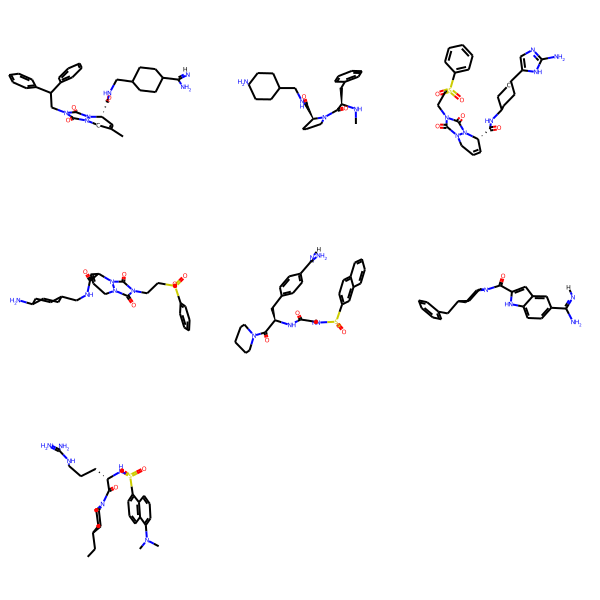

In [9]:
pharmacophore = oph.LigandBasedPharmacophore()
pharmacophore.ligands = ligs_with_confs

Draw.MolsToGridImage(pharmacophore.ligands)

## View 3D structures

In [13]:
lig_ind = 0
conf_ind = 1
nv.show_rdkit(pharmacophore.ligands[lig_ind], conf_ind=conf_ind)

NGLWidget()

## Extracting common pharmacophores

We extract common pharmacophores via recursive distance partitioning algorithm

In [14]:
import openpharmacophore.pharmacophore.ligand_based.rdp as rdp

### Find chemical features

In [15]:
ligands = []
for ii, lig in enumerate(pharmacophore.ligands):
    lig = rdp.Ligand(lig)
    lig.find_features()
    ligands.append(lig)
    
    print(f"\nLigand {legends[ii]} has variant {lig.variant}")
    pprint(lig.feats)


Ligand 1C4V has variant AAADDDHHPRRR
{'A': [(12,), (20,), (23,)],
 'D': [(1,), (10,), (39,)],
 'H': [(3, 4, 5, 6, 7, 8), (38,)],
 'N': [],
 'P': [(2, 1, 39)],
 'R': [(17, 18, 19, 21, 22),
       (26, 27, 28, 29, 30, 31),
       (32, 33, 34, 35, 36, 37)]}

Ligand 1TOM has variant AAAADDDHHHR
{'A': [(1,), (27,), (11,), (18,)],
 'D': [(1,), (19,), (27,)],
 'H': [(21, 22, 23, 24, 25, 26), (13, 14, 15), (0,)],
 'N': [],
 'P': [],
 'R': [(4, 5, 6, 7, 8, 9)]}

Ligand 1D6W has variant AAAAAADDDHHRRR
{'A': [(33,), (7,), (8,), (13,), (21,), (23,)],
 'D': [(24,), (35,), (36,)],
 'H': [(25, 26, 27, 28, 29, 30), (15, 16, 17)],
 'N': [],
 'P': [],
 'R': [(11, 12, 14, 19, 20), (31, 32, 33, 34, 35), (0, 1, 2, 3, 4, 5)]}

Ligand 1D91 has variant AAAAAADDHHRR
{'A': [(32,), (7,), (8,), (13,), (21,), (23,)],
 'D': [(24,), (32,)],
 'H': [(26, 27, 28, 29, 30, 31), (15, 16, 17)],
 'N': [],
 'P': [],
 'R': [(11, 12, 14, 19, 20), (0, 1, 2, 3, 4, 5)]}

Ligand 1DWD has variant AAAAADDDDHHPRRR
{'A': [(1,), (12,)

### Finding K-Point Pharmacophores

In [33]:
min_actives = len(pharmacophore.ligands)
n_points = 3
k_variants = rdp.common_k_point_variants(ligands, n_points, min_actives)

In [34]:
print(f"There are {len(k_variants)} variants of {n_points} points")

There are 666 variants of 3 points


In [35]:
containers = rdp.common_k_point_feature_lists(ligands, k_variants)

print(f"There are {len(containers)} containers")
for c in containers:
    print(f"Container {c.variant} has {len(c)} feat lists")

There are 5 containers
Container AAD has 27188 feat lists
Container AAR has 21624 feat lists
Container ADD has 18210 feat lists
Container ADR has 37476 feat lists
Container DDR has 10854 feat lists


In [36]:
boxes = {}

for cont in containers:
    boxes[cont.variant] = rdp.pharmacophore_partitioning(cont, min_actives)

for var, cont_lists in boxes.items():
    print(f"Variant {var} has {len(cont_lists)} surviving boxes")

Variant AAD has 0 surviving boxes
Variant AAR has 0 surviving boxes
Variant ADD has 12 surviving boxes
Variant ADR has 63 surviving boxes
Variant DDR has 0 surviving boxes


In [38]:
boxes_add = boxes["ADD"]
feat_lists = []

for box in boxes_add:
    scores = rdp.score_common_pharmacophores(box)
    if len(scores) > 0:
        top = scores[0]
        feat_lists.append(box[top[1]])

feat_lists

In [45]:
fl = feat_lists[0] 
points = rdp.feat_list_to_pharma(fl, ligands[fl.id[0]])
view = nv.show_rdkit(
    pharmacophore.ligands[fl.id[0]], conf_id=fl.id[1])
for p in points:
    p.add_to_ngl_view(view)
view

NGLWidget()